# Forecast Green Bond Index

## Project Description
This project aims to forecast the Green Bond Index using machine learning techniques. The Green Bond Index is a benchmark that measures the performance of green bonds, which are fixed-income securities designed to finance projects that have positive environmental benefits.

## Data Sources
1. **S&P Green Bond Index**: Data manually downloaded from [S&P Global](https://www.spglobal.com/spdji/en/indices/sustainability/sp-green-bond-index/#overview).
2. **LSEG Data Library**: Data accessed via API from the London Stock Exchange Group (LSEG).

## Methodology
- **Machine Learning**: Various machine learning models will be employed to y_pred_arima the Green Bond Index based on historical data and other relevant financial indicators. The specific methods include:
    - **ARIMA (AutoRegressive Integrated Moving Average)**: To model and y_pred_arima time series data.
    - **LSTM (Long Short-Term Memory)**: A type of recurrent neural network (RNN) suitable for sequence prediction problems.
    - **Random Forest**: To capture non-linear relationships and interactions between variables.

#### Import Package

In [64]:
#  install packages
# pip install plotly
# pip install pandasql

# import packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as plotly # `plotly` is a library used to render interactive graphs
import sqlite3 as sql
import numpy as np
import tensorflow as tf
# import keras

# import warnings
# warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


## 1. Download Data

### 1.1 S&P green bond index
mannualy download data from
https://www.spglobal.com/spdji/en/indices/sustainability/sp-green-bond-index/#overview

In [65]:
# transform the data into a pandas dataframe and visualize the time series
# Load the Excel file into a DataFrame
SPgreenbond = pd.read_excel('Data/SPgreenbondindex.xls', skiprows=6, nrows=2615)
SPgreenbond

# # Rename the first column using its location (index)
SPgreenbond.columns.values[0] = 'Date'

# Convert 'Date' column to datetime format
SPgreenbond['Date'] = pd.to_datetime(SPgreenbond['Date'])
print(SPgreenbond)

# Save the first and last values of the 'Date' column
starttime = SPgreenbond['Date'].iloc[0]
endtime = SPgreenbond['Date'].iloc[-1]

print(f"Start time: {starttime}")
print(f"End time: {endtime}")


           Date  S&P Green Bond Index
0    2015-01-30                129.36
1    2015-02-02                129.64
2    2015-02-03                130.03
3    2015-02-04                129.91
4    2015-02-05                129.99
...         ...                   ...
2610 2025-02-10                129.01
2611 2025-02-11                128.81
2612 2025-02-12                128.65
2613 2025-02-13                129.67
2614 2025-02-14                130.42

[2615 rows x 2 columns]
Start time: 2015-01-30 00:00:00
End time: 2025-02-14 00:00:00


In [66]:
# Set 'Date' as the index
SPgreenbond_ts=SPgreenbond
print(SPgreenbond_ts)
SPgreenbond_ts=SPgreenbond_ts.set_index('Date')
print(SPgreenbond_ts)

# visualize the time series
fig = plotly.line(SPgreenbond_ts)
fig.show()

           Date  S&P Green Bond Index
0    2015-01-30                129.36
1    2015-02-02                129.64
2    2015-02-03                130.03
3    2015-02-04                129.91
4    2015-02-05                129.99
...         ...                   ...
2610 2025-02-10                129.01
2611 2025-02-11                128.81
2612 2025-02-12                128.65
2613 2025-02-13                129.67
2614 2025-02-14                130.42

[2615 rows x 2 columns]
            S&P Green Bond Index
Date                            
2015-01-30                129.36
2015-02-02                129.64
2015-02-03                130.03
2015-02-04                129.91
2015-02-05                129.99
...                          ...
2025-02-10                129.01
2025-02-11                128.81
2025-02-12                128.65
2025-02-13                129.67
2025-02-14                130.42

[2615 rows x 1 columns]


### 1.2 Download Predictors from LSEP via API
source: 
https://github.com/LSEG-API-Samples/Article.RD.Python.BeginnersGuideToPythonAndDataLibrary/tree/1f88ba19ad7ebe63cc65cd9e7992ea87aff552ee

search for bulk id for variables
https://github.com/LSEG-API-Samples/Example.DataLibrary.Python/blob/lseg-data-examples/Examples/1-Access/EX-1.01.06-Search.ipynb

In [67]:
# # pip install refinitiv-data
# import refinitiv.data as rdp # `rdp` for Refinitive Data Platform
# print(f"Here we are using the LSEG Data Library version {rdp.__version__}")

# ## authentication

# # download config file
# # https://github.com/LSEG-API-Samples/Example.DataLibrary.Python/blob/lseg-data-examples/Configuration/lseg-data.config.json
# # obtain app key from LSEG workspace
# # add app key to config file
# # keep LSEG workspace open

# rdp.open_session(  # the `open_session` function in the `dl` library allows us to authenticate ourselved to the LSEG services.
#     name="desktop.workspace",  # Here we can choose 'desktop.workspace', 'rdp.platform' or any other name you may have given to your session details in your .json configuration file
#     config_name="Data/lseg-data.config.json")  # This is the location of my config file on my machine.

In [68]:
## manually look for a specific variable in workspace:
# find identify code of the variable (RID): search the variable in the workspace
# find field : open data item browser of the variable, use filter - data types find the field
# tricks: upper right ⚙ , opt off Blank Values to filter missing data fields 

# get time-series data of the variable
# help(rdp.get_history) 

# df = rdp.get_history(
#     universe=['LSEG.L',"PLc1"],
#     fields=["Close", "ASK", "TR.Revenue"],
#     interval="monthly",
#     start="2015-01-01",
#     end="2019-10-01")

# print(predictors.count())
# predictors

In [69]:
## look for id and fileds of multiple variables:
# help(rdp.discovery.search)
# help(rdp.content.search.Views)

# https://github.com/LSEG-API-Samples/Example.DataLibrary.Python/blob/lseg-data-examples/Examples/1-Access/EX-1.01.06-Search.ipynb

# keywordlist = [
#     "S&P 500 Bond Index",
#     "Gold Price"
# ]

## basic search
# rdp.discovery.search("IBM Bonds")

# search for multiple varialbes and only show the title and RIC
# for keyword in keywordlist:
#     result = rdp.discovery.search(query=keyword, select="DocumentTitle,RIC") 
#     print(result)

## search for variables with specific conditions and donwload the data
# response1 = rdp.content.search.Definition(
#     view=rdp.content.search.Views.SEARCH_ALL,  # To see what views are available: `help(rdp.content.search.Views)` & `rdp.content.search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
#     query=".STOXX50E",
#     select="DocumentTitle, RIC, StrikePrice, ExchangeCode, ExpiryDate, UnderlyingAsset, " +
#             "UnderlyingAssetName, UnderlyingAssetRIC, ESMAUnderlyingIndexCode, RCSUnderlyingMarket" +
#             "UnderlyingQuoteName, UnderlyingQuoteRIC, InsertDateTime, RetireDate",
#     filter="RCSAssetCategoryLeaf eq 'Option' and RIC eq 'STX*' and DocumentTitle ne '*Weekly*' " +
#     "and CallPutOption eq 'Call' and ExchangeCode eq 'EUX' and " +
#     "ExpiryDate ge 2022-07-10 and ExpiryDate lt 2023-07-22",  # ge (greater than or equal to), gt (greater than), lt (less than) and le (less than or equal to). These can only be applied to numeric and date properties.
#     top=100).get_data()
# searchDf1 = response1.data.df
# searchDf1

# response1 = rdp.content.search.Definition(
#  view=rdp.content.search.Views.SEARCH_ALL,
#  query="").get_data()
# searchDf1 = response1.data.df


In [70]:
# get the list of RIC of variables from AI
varID=[
        # Capital Market  (Bond Index)
        ".SP500BD",  # S&P 500 Bond Index
        # Capital Market  (Stock Market Index)
        ".DJIMI",  # Dow Jones Islamic Market World Index
        ".MIWD00000PUS",  # MSCI World Index
        ".MIWO00002NUS", #MSCI World ESG Leader Index	
        ".SP500",  # S&P 500 Index
        # Commodity Market Indicator
        ".SPGSIA",  # Aluminum index
        "BTC=BTSP",  # Bitcoin Spot Price
        ".TRXFLDGLPUCOAL",  # global Coal Price index
        ".SPGSIC",  # Copper Price
        ".SPGSCT",  # Cotton Price
        "CLc1",  # Crude Oil Price
        "GCc1",  # Gold Price
        "NGc1",  # Natural Gas Price
        "PLc1",  # Platinum Price
        "SIc1",  # Silver Price
        "Wc1",  # Wheat Price
        # Macroeconomic Indicator
        "USCPI=ECI", #US Consumer Price Index (CPI)
        ".DXY",  # US Dollar Index
        "USCPI=ECI", #US Consumer Price Index (CPI)
        "aUSM2/A", #US Money Supply M2
        # ".TRXVUSGOV10U" #government bond 10 year index
        "US10YT=RR",  # US 10Y Treasury Note
        "EU10YT=RR",  # EU 10Y Bund
        "JP10YT=RR",  # Japan 10Y JGB
        "GB10YT=RR",  # UK 10Y Gilt
        "CH10YT=RR",  # Switzerland 10Y T-Bond
        "CA10YT=RR",  # Canada 10Y T-Bond
        "AU10YT=RR",  # Australia 10Y T-Bond
        "NZ10YT=RR",  # New Zealand 10Y T-Bond
        "ZA10YT=RR",  # South Africa 10Y T-Bond
        "BR10YT=RR",  # Brazil 10Y T-Bond
        "IN10YT=RR",  # India 10Y T-Bond
        "CN10YT=RR",  # China 10Y T-Bond
        "RU10YT=RR",  # Russia 10Y T-Bond
        # Sentiment Indicator
        ".SGIXSENT", #SG GLOBAL SENTIMENT index
        # Uncertainty Indicator
        ".VIX",  # CBOE Volatility Index (VIX)
    ]

In [71]:
# check RIC and document title to make sure the variable is correct
# defin = rdp.content.symbol_conversion.Definition(
#     symbols=varID,
#     to_symbol_types=[
#         rdp.content.symbol_conversion.SymbolTypes.RIC,
#         rdp.content.symbol_conversion.SymbolTypes.ISIN])
# def_resp = defin.get_data()
# def_resp.data.df

In [72]:
def download_data(varID, starttime, endtime):
    predictors = pd.DataFrame()
    nan_ids = []

    for i in range(len(varID)):
        try:
            timeseries = rdp.get_history(
                universe=varID[i],
                fields=['TR.PriceClose'],
                start=starttime,
                end=endtime
            )
            if len(timeseries) == 0:
                timeseries = rdp.get_history(
                universe=varID[i],
                fields=['TR.CLOSEPRICE'], # try another field name
                start=starttime,
                end=endtime
            )
            if len(timeseries) == 0:
                timeseries = rdp.get_history(
                universe=varID[i],
                fields=['TR.MIDYIELD'], # try another field name
                start=starttime,
                end=endtime
            )
            if len(timeseries) > 0:
                   # each time series is saved as a column with the RIC as the column name
                timeseries.columns = [varID[i]]
                predictors = pd.concat([predictors, timeseries], axis=1)
        except:
            timeseries=pd.DataFrame()
            print(f"Failed to download {varID[i]}")
            nan_ids.append(varID[i])
            continue

        # nan variable ids
        print(nan_ids)

        # check number of data points for each variable
        print(predictors.count())

        # replace with the feild with more data points
        predictors2 = rdp.get_history(
            universe='PLc1',
            fields=['TR.SETTLEMENTPRICE'],
            start=starttime,
            end=endtime
            
        )
        predictors2.columns = ['PLc1']
        print(predictors2.count())

        # Drop 'PLc1' from predictors if it exists
        predictors = predictors.drop(columns=['PLc1'], errors='ignore')

        # Merge predictors and predictors2 based on index, keeping all rows from both
        predictors = predictors.merge(predictors2[['PLc1']], left_index=True, right_index=True, how='outer')

        print(predictors.count())
        predictors.to_excel("Data/predictors.xlsx") 

        # download monthly variables
        predictors_mon = pd.DataFrame()
        predictors_mon = rdp.get_history(
        universe=["USCPI=ECI", "aUSM2/A"],
        fields=['VALUE'],
        start=starttime,
        end=endtime)

        print(predictors_mon.count())
        predictors_mon.to_excel("Data/predictors_mon.xlsx") 

    return predictors, predictors_mon, nan_ids

# [predictors, predictors_mon, nan_ids]=download_data(varID, starttime, endtime)

## 2 Data Processing

In [73]:
# Load the predictors DataFrame from an Excel file
predictors = pd.read_excel("Data/predictors.xlsx")
predictors_mon = pd.read_excel("Data/predictors_mon.xlsx")

## merge monthly data with daily data
# Convert the date column in predictors to a monthly period
predictors['month'] = predictors['Date'].dt.to_period('M')
predictors_mon['month'] = predictors_mon['Date'].dt.to_period('M')

# Merge the DataFrames on the monthly period
X = pd.merge(predictors, predictors_mon, on='month', how='outer')

# Drop the month column
X = X.drop(columns=['month','Date_y','index'], errors='ignore')
X.rename(columns={'Date_x': 'Date'}, inplace=True)
print(X.count())

Date               3669
.SP500BD           2325
.DJIMI             2621
.MIWD00000PUS      2621
.MIWO00002NUS      2621
.SP500             2527
.SPGSIA            2530
BTC=BTSP           3667
.TRXFLDGLPUCOAL    2370
.SPGSIC            2530
.SPGSCT            2531
CLc1               2529
GCc1               2392
NGc1               2529
SIc1               2051
Wc1                2471
.DXY               2610
.VIX               2556
.SGIXSENT          2512
US10YT=RR          2520
EU10YT=RR          2571
JP10YT=RR          2450
GB10YT=RR          2547
CH10YT=RR          2526
CA10YT=RR          2508
AU10YT=RR          2545
NZ10YT=RR          2513
ZA10YT=RR          2510
BR10YT=RR          2450
IN10YT=RR          2429
CN10YT=RR          2503
RU10YT=RR          2344
PLc1               2527
USCPI=ECI          3654
aUSM2/A            3623
dtype: int64


In [74]:
# Rename columns
column_mapping = {
    ".SP500BD": "S&P 500 Bond Index",
    ".DJIMI": "Dow Jones Islamic Market World Index",
    ".MIWD00000PUS": "MSCI World Index",
    ".MIWO00002NUS": "MSCI World ESG Leader Index",
    ".SP500": "S&P 500 Index",
    ".SPGSIA": "Aluminum Index",
    "BTC=BTSP": "Bitcoin Spot Price",
    ".TRXFLDGLPUCOAL": "Global Coal Price Index",
    ".SPGSIC": "Copper Price",
    ".SPGSCT": "Cotton Price",
    "CLc1": "Crude Oil Price",
    "GCc1": "Gold Price",
    "NGc1": "Natural Gas Price",
    "PLc1": "Platinum Price",
    "SIc1": "Silver Price",
    "Wc1": "Wheat Price",
    "USCPI=ECI": "US_CPI",
    ".DXY": "US Dollar Index",
    "aUSM2/A": "US_M2",
    "US10YT=RR": "US 10Y Treasury Note",
    "EU10YT=RR": "EU 10Y Bund",
    "JP10YT=RR": "Japan 10Y JGB",
    "GB10YT=RR": "UK 10Y Gilt",
    "CH10YT=RR": "Switzerland 10Y T-Bond",
    "CA10YT=RR": "Canada 10Y T-Bond",
    "AU10YT=RR": "Australia 10Y T-Bond",
    "NZ10YT=RR": "New Zealand 10Y T-Bond",
    "ZA10YT=RR": "South Africa 10Y T-Bond",
    "BR10YT=RR": "Brazil 10Y T-Bond",
    "IN10YT=RR": "India 10Y T-Bond",
    "CN10YT=RR": "China 10Y T-Bond",
    "RU10YT=RR": "Russia 10Y T-Bond",
    ".SGIXSENT": "SG Global Sentiment Index",
    ".VIX": "CBOE Volatility Index (VIX)"
}

# Rename columns
X.rename(columns=column_mapping, inplace=True)

# Display the DataFrame with new column names
print(X.head())


        Date  S&P 500 Bond Index  Dow Jones Islamic Market World Index  \
0 2013-06-28            113.4939                                   NaN   
1 2015-01-30                 NaN                               2831.47   
2 2015-01-31                 NaN                                   NaN   
3 2015-02-01                 NaN                                   NaN   
4 2015-02-02                 NaN                               2856.88   

   MSCI World Index  MSCI World ESG Leader Index  S&P 500 Index  \
0               NaN                          NaN            NaN   
1            410.33                       121.02      1994.9904   
2               NaN                          NaN            NaN   
3               NaN                          NaN            NaN   
4            414.10                       122.17      2020.8492   

   Aluminum Index  Bitcoin Spot Price  Global Coal Price Index  Copper Price  \
0             NaN                 NaN                      NaN          

In [75]:
# Merge the DataFrames
data_yX = pd.merge(SPgreenbond,X,on='Date', how='left')

# use SQL to count the number of missing values in each column
# Connect to SQLite (creates a temporary in-memory database)
conn = sql.connect(":memory:")

# Load DataFrame into SQLite
data_yX.to_sql("data_yX", conn, if_exists="replace", index=False)

# Generate the SQL query to count NULL values for each column
columns = data_yX.columns
query = "SELECT " + ", ".join(
    [f'SUM(CASE WHEN "{col}" IS NULL THEN 1 ELSE 0 END) AS "{col}_NULLs"' for col in columns]
) + " FROM data_yX"

# Execute the SQL query
null_counts = pd.read_sql(query, conn)

# Close connection
# conn.close()

# Display the result
print(null_counts)

   Date_NULLs  S&P Green Bond Index_NULLs  S&P 500 Bond Index_NULLs  \
0           0                           0                       295   

   Dow Jones Islamic Market World Index_NULLs  MSCI World Index_NULLs  \
0                                           0                       0   

   MSCI World ESG Leader Index_NULLs  S&P 500 Index_NULLs  \
0                                  0                   88   

   Aluminum Index_NULLs  Bitcoin Spot Price_NULLs  \
0                    85                         1   

   Global Coal Price Index_NULLs  ...  Australia 10Y T-Bond_NULLs  \
0                            249  ...                          70   

   New Zealand 10Y T-Bond_NULLs  South Africa 10Y T-Bond_NULLs  \
0                           102                            105   

   Brazil 10Y T-Bond_NULLs  India 10Y T-Bond_NULLs  China 10Y T-Bond_NULLs  \
0                      165                     189                     179   

   Russia 10Y T-Bond_NULLs  Platinum Price_NULLs  U

### Feature Engineering

Scaling
MinMaxScaler class from the sklearn.preprocessing: scale the data to a specified range, usually between 0 and 1.

Scaling can be beneficial for certain machine learning algorithms that are sensitive to the scale of input features.

In [76]:
print(data_yX.iloc[:,1:].head())

   S&P Green Bond Index  S&P 500 Bond Index  \
0                129.36                 NaN   
1                129.64                 NaN   
2                130.03                 NaN   
3                129.91                 NaN   
4                129.99                 NaN   

   Dow Jones Islamic Market World Index  MSCI World Index  \
0                               2831.47            410.33   
1                               2856.88            414.10   
2                               2887.90            419.24   
3                               2884.48            419.42   
4                               2907.38            422.18   

   MSCI World ESG Leader Index  S&P 500 Index  Aluminum Index  \
0                       121.02      1994.9904        118.1173   
1                       122.17      2020.8492        118.5306   
2                       123.59      2050.0328        119.6910   
3                       123.45      2041.5094        118.9280   
4                       1

In [77]:
# Deal with missing values
# import trading date
import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
trading_days = nyse.schedule(start_date=starttime, end_date=endtime)
trading_days = pd.DataFrame(trading_days.index, columns=['Date'])

#Check for missing values
sample_date=X[['Date']]
ck_missingdate = pd.merge(trading_days, sample_date, left_index=True,right_index=True, how='left')
missingdate = ck_missingdate[ck_missingdate['Date_y'].isna()]
# print(missingdate)

null_df = pd.DataFrame({"Null Values": data_yX.isnull().sum(),
                         "Percentage Null Values": (data_yX.isnull().sum()) / (data_yX.shape[0]) * 100
                         })

print(null_df)


# data_yX.reset_index(inplace=True)
# keywords = ['Date','S&P Green Bond Index', 'S&P 500 Bond Index','MSCI World Index','MSCI World ESG Leader Index',
#             'S&P 500 Index','Crude Oil Price','Natural Gas Price','Bitcoin Spot Price',
#             'US Dollar Index','CBOE Volatility Index (VIX)','SG Global Sentiment Index','US 10Y Treasury Note',
#             'US_CPI','US_M2']
# data_yX = data_yX[keywords]
# data_yX.set_index('Date', inplace=True)

print(data_yX.columns.tolist())



                                      Null Values  Percentage Null Values
Date                                            0                0.000000
S&P Green Bond Index                            0                0.000000
S&P 500 Bond Index                            295               11.281071
Dow Jones Islamic Market World Index            0                0.000000
MSCI World Index                                0                0.000000
MSCI World ESG Leader Index                     0                0.000000
S&P 500 Index                                  88                3.365201
Aluminum Index                                 85                3.250478
Bitcoin Spot Price                              1                0.038241
Global Coal Price Index                       249                9.521989
Copper Price                                   85                3.250478
Cotton Price                                   84                3.212237
Crude Oil Price                       

In [78]:

# Create lagged features
data_yX['S&P Green Bond Index lag1'] = data_yX['S&P Green Bond Index'].shift(1)
data_yX['S&P Green Bond Index lag5'] = data_yX['S&P Green Bond Index'].shift(5)
data_yX['S&P Green Bond Index lag10'] = data_yX['S&P Green Bond Index'].shift(10)

# Create rolling statistics
short_term=10
long_term=100
data_yX['greenbond_index_rolling_mean_5'] = data_yX['S&P Green Bond Index'].rolling(window=short_term).mean()
data_yX['greenbond_index_rolling_mean_5'] = data_yX['S&P Green Bond Index'].rolling(window=short_term).mean()
data_yX['greenbond_index_rolling_std_5'] = data_yX['S&P Green Bond Index'].rolling(window=long_term).std()
data_yX['greenbond_index_rolling_std_5'] = data_yX['S&P Green Bond Index'].rolling(window=long_term).std()


In [79]:

## use forward fill to fill in missing values for macroeconomic indicators

# Forward fill CPI and M2 columns
data_yX[['US_CPI', 'US_M2']] = data_yX[['US_CPI', 'US_M2']].fillna(method='ffill')
 
# Linearly interpolate the other columns
data_yX = data_yX.reset_index()
data_yX.loc[:, ~data_yX.columns.isin(['Date','US_CPI', 'US_M2'])] = (
    data_yX.loc[:, ~data_yX.columns.isin(['Date','US_CPI', 'US_M2'])].interpolate(method='linear')
)
data_yX = data_yX.set_index('Date')
data_yX = data_yX.drop(columns=['index'])

# Time-based interpolation
# data_yX = data_yX.reset_index()
# data_yX['Date'] = pd.to_datetime(data_yX['Date'])
# data_yX = data_yX.set_index('Date')
# data_yX.loc[:, ~data_yX.columns.isin(['Date','US_CPI', 'US_M2'])] = (
#     data_yX.loc[:, ~data_yX.columns.isin(['Date','US_CPI', 'US_M2'])].interpolate(method='time')
# )
# data_yX = data_yX.drop(columns=['index'])

print((data_yX.isnull().sum() / data_yX.shape[0]) * 100)

# remining missing are missing in the beginning of the time series,drop them

data_yX.dropna(inplace=True)
print((data_yX.isnull().sum() / data_yX.shape[0]) * 100)

S&P Green Bond Index                     0.000000
S&P 500 Bond Index                      11.242830
Dow Jones Islamic Market World Index     0.000000
MSCI World Index                         0.000000
MSCI World ESG Leader Index              0.000000
S&P 500 Index                            0.000000
Aluminum Index                           0.000000
Bitcoin Spot Price                       0.000000
Global Coal Price Index                  9.483748
Copper Price                             0.000000
Cotton Price                             0.000000
Crude Oil Price                          0.000000
Gold Price                               0.000000
Natural Gas Price                        0.000000
Silver Price                             0.000000
Wheat Price                              0.000000
US Dollar Index                          0.000000
CBOE Volatility Index (VIX)              0.000000
SG Global Sentiment Index                0.000000
US 10Y Treasury Note                     0.000000


### Split training, validation, and test sets

In [80]:
from sklearn.model_selection import train_test_split

X = data_yX.drop(columns=['S&P Green Bond Index'])
y = data_yX['S&P Green Bond Index']  

# Split into training + validation and test sets (80% train + validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# shuffle=False ensures that the order of the samples is preserved

# Split the training + validation set into training and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

# Output the sizes of each set
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 1392 samples
Validation set size: 464 samples
Test set size: 465 samples


### Scale variables
Scaling after splitting the dataset to prevent data leakage.

In [81]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

y_train = scaler.fit_transform(pd.DataFrame(y_train)) 
y_val = scaler.fit_transform(pd.DataFrame(y_val)) 
y_test = scaler.fit_transform(pd.DataFrame(y_test)) 


## 3. Model Selection

In [82]:

def plot_training_validation_loss(history, figsize=(10, 6)):
    """
    Plots the training and validation loss from a model's training history.

    Parameters:
    ----------
    history : History object
        The History object returned from model.fit() containing loss and val_loss.
    figsize : tuple
        The size of the figure (width, height) in inches.
    """
    plt.figure(figsize=figsize)
    
    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    
    # Make sure 'val_loss' exists in history to avoid errors
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
        
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

                           
def plot_prediction_comparison(y_true, y_pred, figsize=(10, 6)):
    """
    Plots the true values vs. the predicted values.

    Parameters:
    ----------
    y_true : array-like
        Array of true values.
    y_pred : array-like
        Array of predicted values.
    figsize : tuple
        The size of the figure (width, height) in inches.
    """
    plt.figure(figsize=figsize)
    plt.plot(y_true, label='Real Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Comparison of Real and Predicted Values')
    plt.legend()
    plt.show()


### 3.1 ARIMA

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-11040.101, Time=4.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-10996.442, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-11043.233, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-11038.575, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-10998.290, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-11043.211, Time=0.12 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-11045.966, Time=1.18 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-11043.919, Time=1.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-11041.562, Time=0.35 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-10997.989, Time=1.53 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-11046.645, Time=1.30 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-11044.402, Time=0.39 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=-11044.606, Time=1.52 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-11042.821, Time=2.39 sec
 ARIMA(3,1,0)(2,0,0)[12] intercept

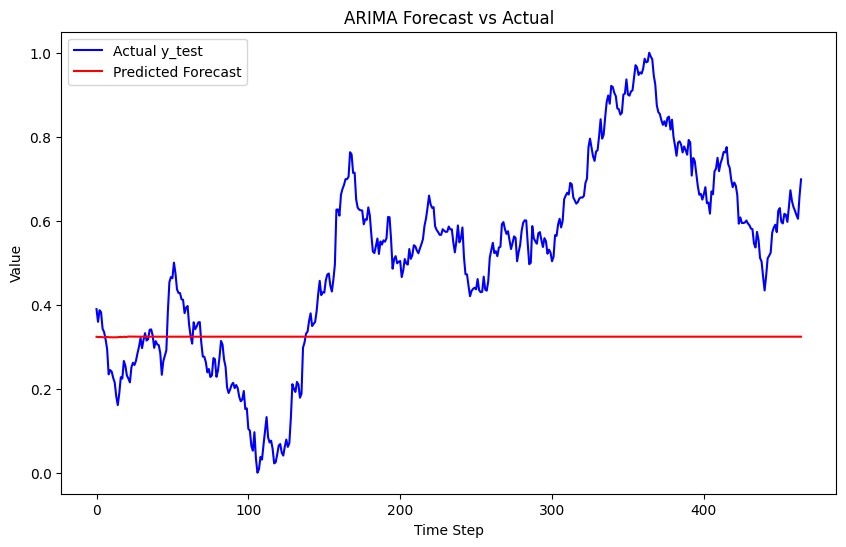

In [83]:
from pmdarima import auto_arima

# # Auto ARIMA model search for best parameters
arima_mdl = auto_arima(np.concatenate([y_train, y_val]), seasonal=True, m=12,  stepwise=True, trace=True)

# Forecast on the test set (y_test)
y_pred_arima = arima_mdl.predict(n_periods=len(y_test))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual y_test', color='blue')
plt.plot(y_pred_arima, label='Predicted Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Optionally, calculate the performance metric (e.g., Mean Squared Error)
mse_arima = mean_squared_error(y_test, y_pred_arima)
r2_arima = r2_score(y_test, y_pred_arima)


### 3.2 Neural Networks: LSTM

In [84]:
# For LSTM use rolling windows to create samples
def create_sequences(X, y, time_steps):
    Xs, ys = [], []  # Initialize empty lists to store input sequences and target values
    for i in range(len(X) - time_steps): 
        Xs.append(X[i:i + time_steps])  # Append a sequence of length 'time_steps' from X to Xs
        ys.append(y[i + time_steps])  # Append the corresponding target value from y to ys
    return np.array(Xs), np.array(ys)  # Convert lists to NumPy arrays and return

# Define the number of time steps
time_steps = 10 # use previous 10 days to predict the next day
X_train_rwseq, y_train_rwseq = create_sequences(X_train, y_train, time_steps)
X_val_rwseq, y_val_rwseq = create_sequences(X_val, y_val, time_steps)
X_test_rwseq, y_test_rwseq = create_sequences(X_test, y_test, time_steps)

print(X_train_rwseq.shape,y_train_rwseq.shape)

(1382, 10, 39) (1382, 1)


In [85]:
print(X_train_rwseq.shape)
print(X_train_rwseq.shape[1])

(1382, 10, 39)
10


shape of the predictors/features: (samples/total time periods, time step, number of features)
samples/total time periods: same as the number of periods of the target y in the tranining set
time step: the number of previous periods used to predict the next period
number of feature: number of predicotrs/features/macor or finantial variables used to predict the target index 

In [86]:
# Create a neural network model
from tensorflow.keras.optimizers import Adam

# dimensions of the input data
time_steps = X_train_rwseq.shape[1] #time steps in the input data
n_features = X_train_rwseq.shape[2] # number of features/predictors in the input data

model = Sequential() # Create a sequential model, output of the previous layer is the input of the next layer

# First layer: Add a Long Short-Term Memory (LSTM) layer with 50 units, using ReLU activation function,
model.add(LSTM(units=100, return_sequences=True, activation='relu', input_shape=(time_steps, n_features)))
# units: output dimension , the number of memory cells
# return_sequences=False:layer will return only the output of the last time step for each input sequence. 
# return_sequences=True: LSTM layer will return the full sequence of outputs for each input sequence.
# in the first layer set return full sequence of outputs for each input sequence to be used in the next LSTM layer

# randomlly drop x% of the neurons to prevent overfitting
model.add(Dropout(0))
#
# set return one value
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0))

# Final layer: set return one value
model.add(Dense(units=1))

# Compile the model using the Adam optimizer and mean squared error loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# optimizer='adam': Use the Adam optimization algorithm
# loss='mse': Use mean squared error as the loss function
# metrics=['mae']: Track mean absolute error as an additional metric during training

# Display a summary of the neural network model architecture
model.summary()

d:\Tool\DataAnalysis\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        56,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,501 (533.21 KB)

 Trainable params: 136,501 (533.21 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
# history = model.fit(X_train_rwseq, y_train_rwseq, epochs=100, batch_size=32, validation_data=(X_val_rwseq, y_val_rwseq),
                    # callbacks=[early_stopping])

# fit model
lstm_mdl = model.fit(X_train_rwseq, y_train_rwseq, epochs=50, batch_size=16, validation_data=(X_val_rwseq, y_val_rwseq), verbose=1)
# Batch size: how many pieces of data (examples) you show the model at one time before you update its internal parameters (weights).
#  if your batch size is 32, the model sees 32 examples, calculates how much it’s wrong (the error), and then adjusts its parameters. Then it moves on to the next 32 examples, and so on.

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0289 - val_loss: 0.0050
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9309e-04 - val_loss: 0.0054
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7535e-04 - val_loss: 0.0052
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1165e-04 - val_loss: 0.0034
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2216e-04 - val_loss: 0.0071
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5331e-04 - val_loss: 0.0062
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.7724e-04 - val_loss: 0.0075
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5851e-04 - val_loss: 0.0046
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7207e-04 - val_loss: 0.0060
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.6475e-04 - val_loss: 0.0074
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9233e-04 - val_loss: 0.0108
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━

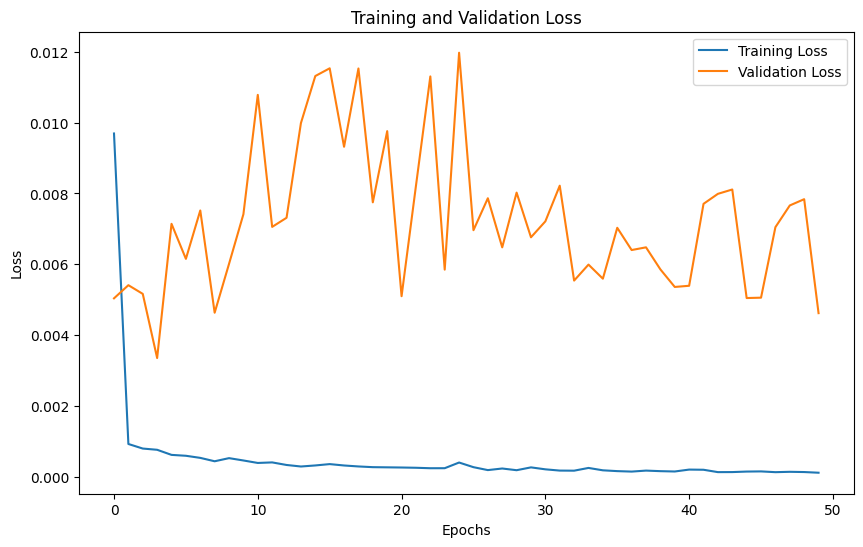

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


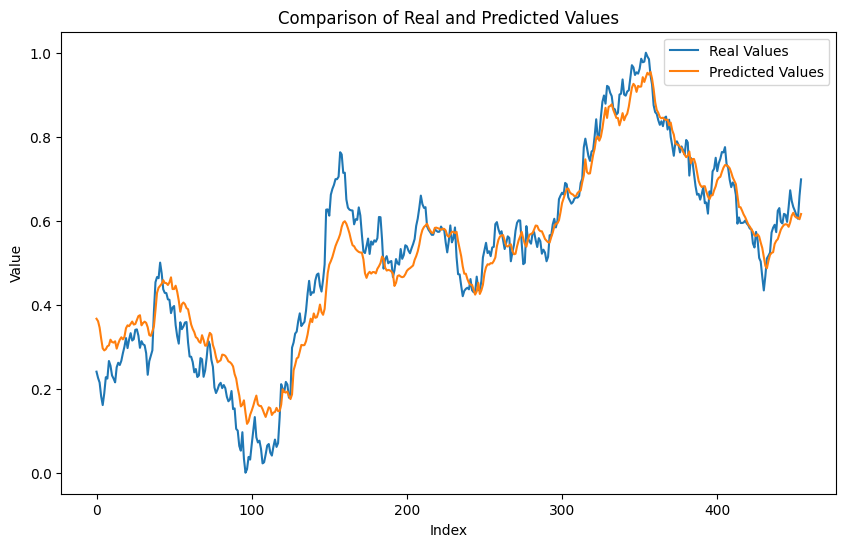

In [88]:
plot_training_validation_loss(lstm_mdl)

y_pred_lstm = model.predict(X_test_rwseq)

# evaluate forecast accuracy
mse_lstm = mean_squared_error(y_test_rwseq, y_pred_lstm)
r2_lstm = r2_score(y_test_rwseq, y_pred_lstm)

plot_prediction_comparison(y_test_rwseq, y_pred_lstm)

#### Hyperparameter Tuning
Tuning the following hyperparameters

units_layer1: Number of units in the first LSTM layer

dropout_layer1: Dropout rate for the first LSTM layer

units_layer2: Number of units in the second LSTM layer

dropout_layer2: Dropout rate for the second LSTM layer

learning_rate: Learning rate for the Adam optimizer

In [89]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    """
    Build and compile a Keras model based on hyperparameters passed in.
    """
    
    model = Sequential()
    
    # First LSTM layer: search over possible number of units
    # e.g. from 50 to 200 units, stepping by 50
    model.add(LSTM(
        units=hp.Int('units_layer1', min_value=50, max_value=200, step=50),
        return_sequences=True,
        activation='relu',
        input_shape=(time_steps, n_features)
    ))
    
    # Dropout rate for first LSTM
    model.add(Dropout(
        rate=hp.Float('dropout_layer1', min_value=0.0, max_value=0.5, step=0.1)
    ))
    
    # Second LSTM layer: search number of units
    model.add(LSTM(
        units=hp.Int('units_layer2', min_value=50, max_value=200, step=50),
        return_sequences=False
    ))
    
    # Dropout rate for second LSTM
    model.add(Dropout(
        rate=hp.Float('dropout_layer2', min_value=0.0, max_value=0.5, step=0.1)
    ))
    
    # Final Dense layer
    model.add(Dense(units=1))
    
    # Learning rate for Adam optimizer
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=lr)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model


In [101]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,            # The model-building function you defined
    objective='val_loss',   # Objective to optimize (can also be 'val_mae', etc.)
    max_trials=10,          # Number of different hyperparameter settings to try
    executions_per_trial=1, # Number of times to train each model (for averaging results)
    overwrite=True,
    directory='tuning',
    project_name='lstm_tuning'
)

# Display search space summary
tuner.search_space_summary()

# Run the hyperparameter search
tuner.search(X_train_rwseq, y_train_rwseq,
             epochs=20,
             batch_size=16,
             validation_data=(X_val_rwseq, y_val_rwseq),
             verbose=1)

# Show the search results
tuner.results_summary()


Trial 10 Complete [00h 00m 17s]
val_loss: 0.0018604743527248502

Best val_loss So Far: 0.0018604743527248502
Total elapsed time: 00h 03m 15s
Results summary
Results in tuning\lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 09 summary
Hyperparameters:
units_layer1: 50
dropout_layer1: 0.1
units_layer2: 150
dropout_layer2: 0.4
learning_rate: 0.0006112420398328798
Score: 0.0018604743527248502

Trial 04 summary
Hyperparameters:
units_layer1: 50
dropout_layer1: 0.0
units_layer2: 150
dropout_layer2: 0.1
learning_rate: 0.0016740809594745873
Score: 0.002099469304084778

Trial 02 summary
Hyperparameters:
units_layer1: 150
dropout_layer1: 0.0
units_layer2: 100
dropout_layer2: 0.4
learning_rate: 0.002379085289944031
Score: 0.002679623430594802

Trial 00 summary
Hyperparameters:
units_layer1: 200
dropout_layer1: 0.2
units_layer2: 150
dropout_layer2: 0.1
learning_rate: 0.0015289905806123777
Score: 0.0028648748993873596

Trial 06 summary
Hyperparameters:
units_la

In [102]:
# Get the top hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best number of units for the first LSTM layer:", best_hps.get('units_layer1'))
print("Best dropout for the first LSTM layer:", best_hps.get('dropout_layer1'))
print("Best number of units for the second LSTM layer:", best_hps.get('units_layer2'))
print("Best dropout for the second LSTM layer:", best_hps.get('dropout_layer2'))
print("Best learning rate:", best_hps.get('learning_rate'))

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

# Train the best model from scratch with more epochs
LSTM_hpt = best_model.fit(
    X_train_rwseq, 
    y_train_rwseq, 
    validation_data=(X_val_rwseq, y_val_rwseq),
    epochs=50,
    batch_size=16,
    verbose=1
)


Best number of units for the first LSTM layer: 50
Best dropout for the first LSTM layer: 0.1
Best number of units for the second LSTM layer: 150
Best dropout for the second LSTM layer: 0.4
Best learning rate: 0.0006112420398328798


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 50)         │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150)            │       120,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,751 (542.00 KB)

 Trainable params: 138,751 (542.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0443 - mae: 0.1442 - val_loss: 0.0170 - val_mae: 0.1039
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - mae: 0.0573 - val_loss: 0.0118 - val_mae: 0.0874
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - mae: 0.0490 - val_loss: 0.0056 - val_mae: 0.0641
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - mae: 0.0432 - val_loss: 0.0064 - val_mae: 0.0675
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - mae: 0.0412 - val_loss: 0.0051 - val_mae: 0.0593
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - mae: 0.0399 - val_loss: 0.0042 - val_mae: 0.0544
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mae: 0.0374 - val_loss: 0.0047 - val_mae: 0.0563
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - mae: 0.0363 - val_loss: 0.0034 - val_mae: 0.0486
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mae:

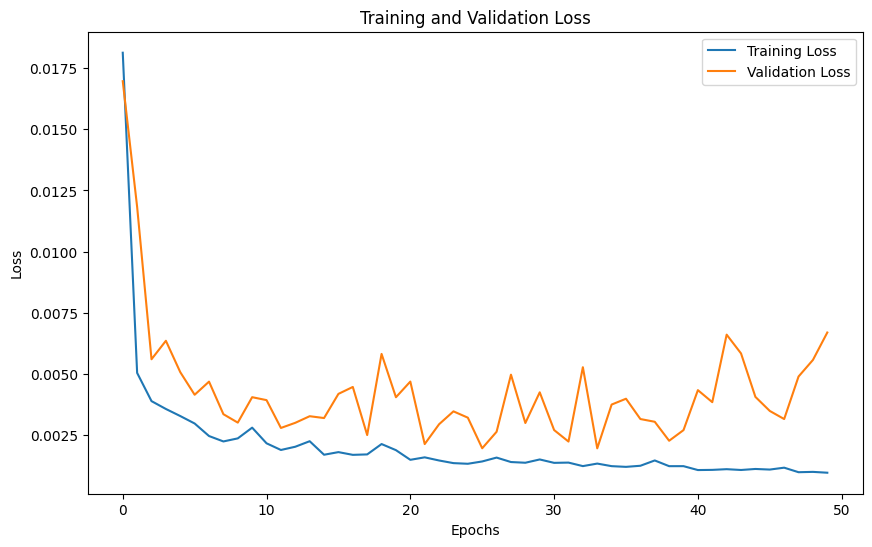

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


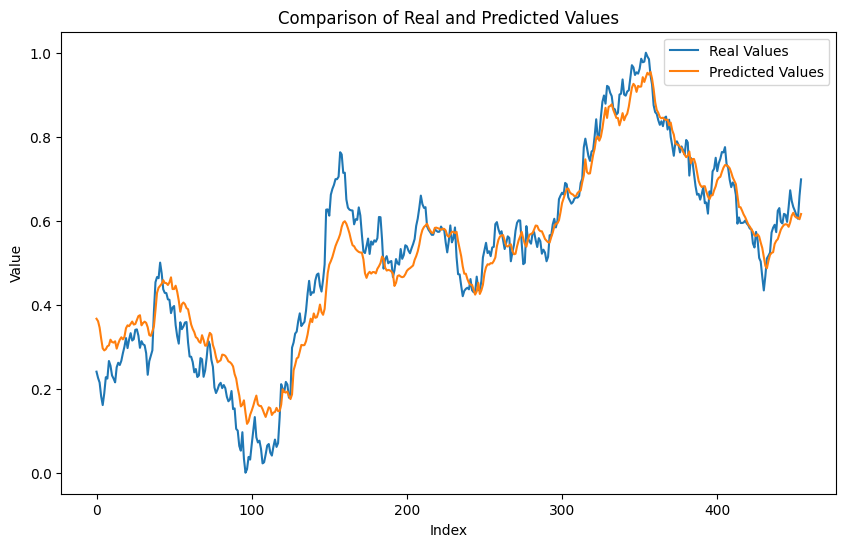

In [103]:
plot_training_validation_loss(LSTM_hpt)

y_pred_lstm_ht = model.predict(X_test_rwseq)

# evaluate forecast accuracy
mse_lstm_ht = mean_squared_error(y_test_rwseq, y_pred_lstm_ht)
r2_lstm_ht = r2_score(y_test_rwseq, y_pred_lstm_ht)

plot_prediction_comparison(y_test_rwseq, y_pred_lstm_ht)


### 3.3 Random Forest

In [112]:
print(X_train.shape,y_train.shape)
print(type(X_train))
print(type(y_train))

print(X_test.shape,y_test.shape)
print(type(X_test))
print(type(y_test))

(1392, 39) (1392, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(465, 39) (465, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [113]:
from sklearn.ensemble import RandomForestRegressor

rf_mdl = RandomForestRegressor()
rf_mdl.fit(X_train, y_train.reshape(-1))

RandomForestRegressor()

In [114]:
from sklearn.ensemble import RandomForestRegressor

rf_mdl = RandomForestRegressor()
rf_mdl.fit(X_train, y_train.reshape(-1))

# Predict the index on the test data
y_pred_rf = rf_mdl.predict(X_test)

# Calculate the Mean Squared Error of the model
mse_rd = mean_squared_error(y_test.reshape(-1), y_pred_rf)

# Calculate the R-squared score of the model
r2_rd = r2_score(y_test.reshape(-1), y_pred_rf)

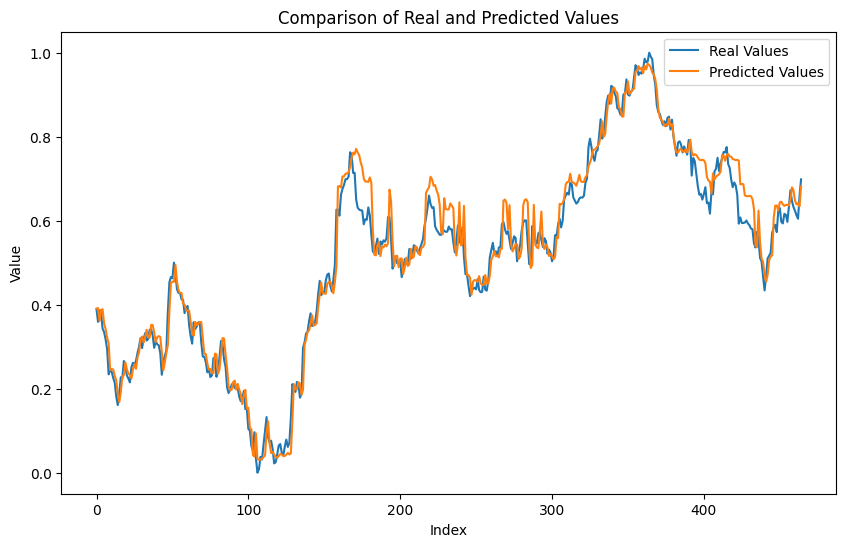

In [115]:
plot_prediction_comparison(y_test.reshape(-1), y_pred_rf)


## 4.Model Evaluation

In [116]:
models = pd.DataFrame({
    'Model' : ['ARIMA','LSTM','LSTM_ht',  
               'Random Forest Regression'],
    'Error' : [mse_arima,mse_lstm,mse_lstm_ht, mse_rd]
})


models = models.sort_values(by = 'Error', ascending = True, ignore_index=True)

models["Error"] = models["Error"].apply(lambda x: round(x,6))
# models["Score"] = models["Score"].apply(lambda x: f'{x:.2e}')
models

models

,Model,Error
0,Random Forest Regression,0.001668
1,LSTM,0.003672
2,LSTM_ht,0.003672
3,ARIMA,0.088559


In [117]:
import plotly.express as px
fig = px.bar(models,
       x="Error",
       y="Model",
       text="Error",
       color="Error",
       template="plotly_dark",
       title="Models Comparision"
      )

fig.show()